# Safe Driver prediction
In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year

By 
- James Dietle @jamesdietle
- Devan Govender @dgovender

Source:
https://github.com/jamesdietle/PortoDriver

Referances:
- Who we are borrowing from Jeremy Howard's Rossman
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## Next Steps
1. Implement predictions on the test set.
2. Validate accuracy

# 1. Dependencies
Things that we need to function or that are just nice
    
    - import functions 
    - correct paths and folders
    - cell noises

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Gives times for each block 
get_ipython().magic('load_ext cellevents')

# Set up paths on computer
path = '/home/jd/data/PortoDriver/'

## Import up sound alert dependencies; I really like sounds
from IPython.display import Audio, display

def allDone():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/eb_win.wav', autoplay=True))
    
def RunningEpochs():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/enterbattle.wav', autoplay=True))

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator


time: 656 ms


In [4]:
#Running on GPU1
torch.cuda.device(0),torch.cuda.set_device(0),torch.cuda.current_device()

(<torch.cuda.device at 0x7fe890615a20>, None, 0)

time: 12.1 ms


# 2. Functions
Functions being run by the program

Might want to go look at this one
http://neuroplausible.com/gini

In [5]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

time: 2.35 ms


In [6]:
# Borrowed from 
# http://www.pythonexample.com/code/gini%20coefficient%20metric/
def gini_normalized(y_pred, targ):
  return gini(y_pred, targ) / gini(y_pred, y_pred)

def gini(actual, pred, cmpcol = 0, sortcol = 1):
  assert( len(actual) == len(pred) )
  all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
  all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
  totalLosses = all[:,0].sum()
  giniSum = all[:,0].cumsum().sum() / totalLosses
  giniSum -= (len(actual) + 1) / 2.
  return giniSum / len(actual)

time: 7.3 ms


In [7]:
#
from sklearn.metrics import roc_auc_score

inv_log = lambda x : np.exp(x)

def gini_metric(preds, targs):
    preds = inv_log(preds)
    auc = roc_auc_score(y_true=targs, y_score=preds)
    return 2 * auc - 1

time: 2.82 ms


# 3. Load in data
Loads the data we are working with into the program
- Data set provided
- Other unique datasets that would help

We are training to target

In [8]:
samplesub = pd.read_csv(f'{path}sample_submission.csv', low_memory=False)
test = pd.read_csv(f'{path}test.csv', low_memory=False)
train = pd.read_csv(f'{path}train.csv', low_memory=False)

time: 7.83 s


In [9]:
# Sample size to speed everything up
size = 3000
#test = test[:size]
#train = train [:size]

time: 955 µs


In [10]:
samplesub[:5]

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


time: 6.18 ms


In [11]:
test[:5].columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

time: 2.44 ms


# 4. Manipulate Data
Prepares the data for training, determines features
- Cuts into sets
- Determines features
- Augments data
	1. More data
	2. Data augmentation
	3. Generalize wel with architectures
	4. Add regularization
    5. Reduce architecture complexity

# 5. Prepare Model
Sets up the model
    - choose optimizer
    - choose format
    - choose loss function

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [12]:
## Move training set over
joined = train
joined_test = test

time: 910 µs


In [13]:
# Adding the validation set to the training set
#joined=joined.append(test)

time: 632 µs


In [14]:
## Just changed all of this no idea if it helps
## This works, but appears to break later
#joined=joined.replace(-1, np.NaN)

##
#joined=joined.fillna(0)

time: 927 µs


In [15]:
# Should this be changed?
joined.target=joined.target.replace(0, .0001)
joined.target=joined.target.replace(1, .9999)
joined_test['target']=0

time: 61.4 ms


In [16]:
joined.to_feather(f'{path}joined')
joined_test.to_feather(f'{path}joined_test')

time: 1.36 s


## Create Features

In [17]:
joined = pd.read_feather(f'{path}joined')
joined_test = pd.read_feather(f'{path}joined_test')

time: 223 ms


In [18]:
cat_vars = [
    #'id', 
    'ps_ind_02_cat', 
       'ps_ind_04_cat', 'ps_ind_05_cat','ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat',
        'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin'
  # ]# Contin variables
        'ps_car_11', 'ps_car_12', 'ps_ind_14', 'ps_ind_15','ps_ind_01','ps_ind_03','ps_reg_01',
        'ps_reg_02', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 
        'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
        'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

#contin_vars = ['ps_car_11', 'ps_car_12', 'ps_car_13','ps_ind_14', 'ps_ind_15','ps_ind_01','ps_ind_03','ps_reg_01','ps_reg_02', 'ps_reg_03', 'ps_car_14',
#       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
#       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
 #      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

contin_vars = ['ps_reg_03', 'ps_car_13', 'ps_car_14']

n = len(joined); n

595212

time: 6.63 ms


In [19]:
type(cat_vars)

list

time: 1.73 ms


In [20]:
samp_size = n
joined_samp = joined
joined_samp_test = joined_test

time: 996 µs


In [21]:
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    joined_test[v] = joined_test[v].astype('category').cat.as_ordered()
for v in contin_vars: 
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')
dep = 'target'

joined = joined[cat_vars+contin_vars+[dep,'id']]
joined_test = joined_test[cat_vars+contin_vars+[dep,'id']]

time: 3.52 s


In [22]:
joined_samp = joined.set_index('id')
joined_samp_test = joined_test.set_index('id')
#??joined.set_index

time: 44.9 ms


In [23]:
df, y, nas, mapper = proc_df(joined_samp, 'target', do_scale=True)
yl = y

time: 3.66 s


In [24]:
df_test, _, nas, mapper = proc_df(joined_samp_test, 'target', do_scale=True, #skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

time: 5.41 s


In [25]:
nas

{}

time: 1.9 ms


In [26]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['ps_car_11'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_12'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_13'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_ind_14'], StandardScaler(copy=True, with_mean=True, with_st...n=True, with_std=True)), (['ps_calc_14'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

time: 3.16 ms


In [27]:
len(joined)

595212

time: 1.87 ms


In [28]:
df.index[50]

125

time: 1.86 ms


In [29]:
# makes a 30% validation size
val_idx_list=train['id'].tolist()
len(val_idx_list)
val_idx = random.sample(val_idx_list, int(len(val_idx_list)*.3))
len(val_idx_list), len(val_idx)

(595212, 178563)

time: 168 ms


In [30]:
val_idx.sort()

time: 80.8 ms


In [31]:
## Get the index for something inside the list
val_target=train.target[train['id'].isin(val_idx)].tolist()
val_idx=train.index[train['id'].isin(val_idx)].tolist()
len(val_idx), len(val_target)

(178563, 178563)

time: 82.7 ms


# 6. Runs the training
Run it the training! Save the weights! 
- Make the predictions


In [32]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl, cat_flds=cat_vars, bs=512, 
                                       test_df=df_test)

time: 934 ms


In [33]:
max_log_y = np.max(yl)

# 1.2 doesn't make sense
#y_range = (0, max_log_y*1.2)
#y_range = (0, max_log_y*1)
y_range = (0, 1)

time: 2.37 ms


In [34]:
max_log_y,y_range

(0.99990000000000001, (0, 1))

time: 1.85 ms


In [35]:
#cat_sz = {c: len(joined_samp[c].cat.categories)+1 for c in cat_vars}
cat_sz = {c: len(joined[c].cat.categories)+1 for c in cat_vars}
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz.items()]

time: 3.34 ms


In [36]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.01,0.1], y_range=y_range)
                    #0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

time: 2min 13s


In [37]:
RunningEpochs()

time: 3.39 ms


In [38]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.03764  0.03598]                                  

time: 10 s


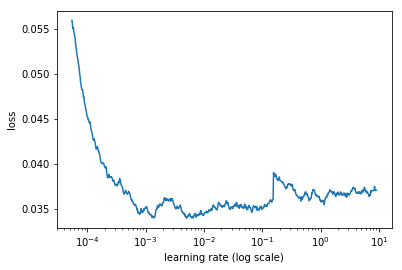

time: 329 ms


In [ ]:
m.sched.plot(100)

In [ ]:
m.fit(lr, 4, metrics=[gini_normalized], cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

[ 0.       0.03643  0.03597  0.00948]                         
  4%|▍         | 32/814 [00:01<00:28, 27.15it/s, loss=0.0375]

In [ ]:
m.lr_find()

In [ ]:
m.sched.plot(100)

In [ ]:
allDone()

In [ ]:
lr=1e-3

In [ ]:
m.fit(lr, 4, metrics=[gini_normalized], cycle_len=3, cycle_mult=2)

## Predictions

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
print(x)
print(y)

In [ ]:
exp_rmspe(x,y)

In [ ]:
pred_test=m.predict(True)

In [ ]:
joined_test['pred_target']=pred_test

In [ ]:
predictions=m.predict()

# 7. Analyze Results
Are they what are expected? 
- Graph the results
- What are the most important features
- What do tough predictions look like? Easy predictions?

In [ ]:
check=joined_test[['id', 'target','pred_target']]
check[5:10]

In [ ]:
predictions.max(), predictions.min()

In [ ]:
predictions[:5]

In [ ]:
# Clips them down to something more reasonable
predictions[predictions > .999] = .999
predictions[predictions < .0001] = .0001

In [ ]:
allDone()

In [ ]:
predictions=predictions.tolist()

In [ ]:
predictions = [item[0] for item in predictions]

In [ ]:
# If nothing changes these should all be the same number
len(val_idx), len(predictions), len(val_target)

In [ ]:
## Validation set predicted target... I see I am very far off.
submission = pd.DataFrame({'id': val_idx, 'pred_target': predictions, 'target': val_target})

In [ ]:
# Grab 5 largest
submission.nlargest(5, 'pred_target')

In [ ]:
#Grab the 5 smallest 
submission.nsmallest(5, 'pred_target')

In [ ]:
## Looks at the ones equal to target 1; These should be high
submission.loc[submission['target'] == .9999][:5]

In [ ]:
## Looks at the ones equal to target 0; These should be low
submission.loc[submission['target'] == 0.0001][:5]

# 8. Submit!
- Get it put into a submitable template
- Save results

In [ ]:
## Sets up the 
submission = pd.DataFrame({'id': joined_test.id, 'target': joined_test.pred_target})
# Shows 5 to ensure formatting is correct
submission[:10]

In [ ]:
# Makes the submission name out of folders
path2 = path +'submits/'
## labels submissions in order
numFiles=len(os.listdir(path2))
subm_name = 'submission'+str(numFiles)+'.csv.gz'

In [ ]:
## prints it out to downloaded
submission.to_csv((path2+subm_name), index=False, compression='gzip')
print ('http://localhost:8888/view/data/PortoDriver/submits/'+subm_name)